Iteration 0, Loss: 1.1899722644036834
Iteration 1, Loss: 1.1857924028487095
Iteration 2, Loss: 1.1816231243433013
Iteration 3, Loss: 1.1774644456061847
Iteration 4, Loss: 1.1733163856208255
Iteration 5, Loss: 1.1691789656254166
Iteration 6, Loss: 1.16505220909715
Iteration 7, Loss: 1.1609361417310067
Iteration 8, Loss: 1.1568307914133202
Iteration 9, Loss: 1.1527361881903426
Iteration 10, Loss: 1.148652364232073
Iteration 11, Loss: 1.144579353791577
Iteration 12, Loss: 1.140517193160048
Iteration 13, Loss: 1.1364659206178587
Iteration 14, Loss: 1.1324255763818227
Iteration 15, Loss: 1.1283962025489465
Iteration 16, Loss: 1.1243778430368514
Iteration 17, Loss: 1.1203705435211673
Iteration 18, Loss: 1.1163743513700668
Iteration 19, Loss: 1.1123893155762266
Iteration 20, Loss: 1.1084154866863787
Iteration 21, Loss: 1.1044529167287516
Iteration 22, Loss: 1.1005016591385353
Iteration 23, Loss: 1.0965617686816482
Iteration 24, Loss: 1.0926333013769836
Iteration 25, Loss: 1.088716314417347
It

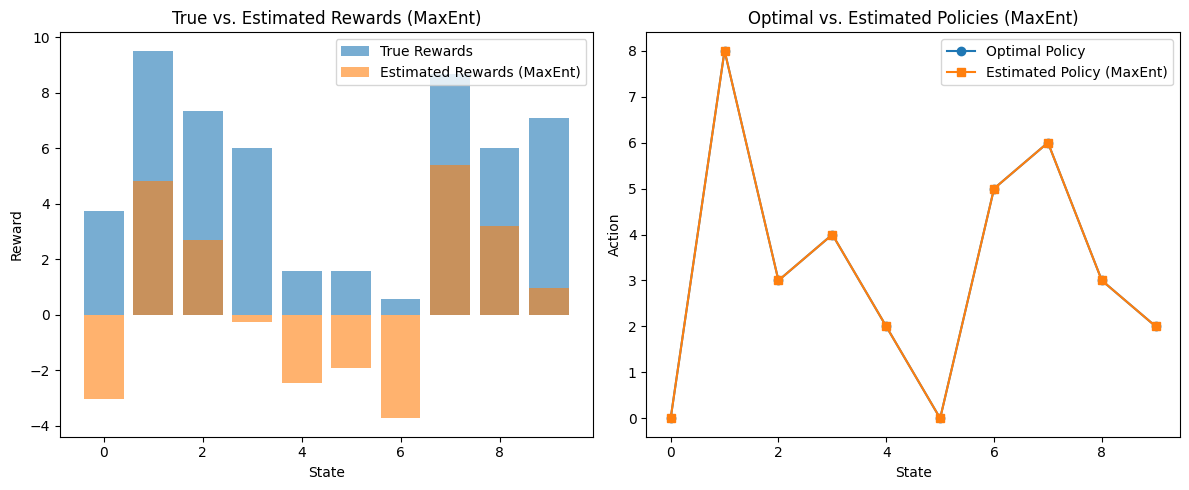

True Reward Function:
[3.75 9.51 7.32 5.99 1.56 1.56 0.58 8.66 6.01 7.08]

Estimated Reward Function (MaxEnt):
[-3.02  4.81  2.67 -0.25 -2.46 -1.92 -3.73  5.39  3.2   0.96]

Difference in Reward Function:
[6.77 4.7  4.65 6.23 4.02 3.48 4.31 3.27 2.82 6.12]

Optimal Policy:
[0 8 3 4 2 0 5 6 3 2]

Estimated Policy (MaxEnt):
[0 8 3 4 2 0 5 6 3 2]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv

def generate_random_mdp(num_states, num_actions, max_reward):
    R_true = np.random.uniform(0, max_reward, size=num_states)
    Pssa = np.zeros((num_states, num_states, num_actions))
    for s in range(num_states):
        for a in range(num_actions):
            probabilities = np.random.rand(num_states)
            probabilities /= probabilities.sum()
            Pssa[s, :, a] = probabilities
    return R_true, Pssa

def value_iteration(num_states, num_actions, rewards, transition_probabilities, discount_factor, epsilon=1e-6, max_iterations=1000):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    for _ in range(max_iterations):
        V_prev = V.copy()
        Q = np.zeros((num_states, num_actions))
        for s in range(num_states):
            for a in range(num_actions):
                Q[s, a] = rewards[s] + discount_factor * transition_probabilities[s, :, a] @ V_prev
        V_new = np.max(Q, axis=1)
        policy = np.argmax(Q, axis=1)
        if np.max(np.abs(V_new - V_prev)) < epsilon:
            V = V_new
            break
        V = V_new
    return V, policy

def generate_trajectory(Pssa, policy, start_state, num_states, max_steps=100):
    trajectory = []
    state = start_state
    for _ in range(max_steps):
        action = policy[state]
        next_state_prob = Pssa[state, :, action]
        next_state = np.random.choice(range(num_states), p=next_state_prob)
        trajectory.append((state, action, next_state))
        state = next_state
    return trajectory

def generate_trajectories(num_trajectories, Pssa, policy, num_states, start_states=None, max_steps=100):
    trajectories = []
    if start_states is None:
        start_states = range(num_states)
    for _ in range(num_trajectories):
        start_state = np.random.choice(start_states)
        traj = generate_trajectory(Pssa, policy, start_state, num_states, max_steps)
        trajectories.append(traj)
    return trajectories

def state_features(num_states):
    return np.identity(num_states)

def feature_expectations(features, trajectories, discount_factor):
    num_features = features.shape[1]
    mu = np.zeros(num_features)
    for traj in trajectories:
        for t, (s, a, s_next) in enumerate(traj):
            mu += (discount_factor ** t) * features[s]
    mu /= len(trajectories)
    return mu

def initial_state_distribution(num_states, trajectories):
    d0 = np.zeros(num_states)
    for traj in trajectories:
        start_state = traj[0][0]
        d0[start_state] += 1
    d0 /= len(trajectories)
    return d0

def maxent_value_iteration(num_states, num_actions, Pssa, reward, discount, eps=1e-5):
    V = np.zeros(num_states)
    delta = np.inf
    while delta > eps:
        V_old = V.copy()
        Q = np.zeros((num_states, num_actions))
        for s in range(num_states):
            for a in range(num_actions):
                Q[s, a] = reward[s] + discount * Pssa[s, :, a] @ V_old
        V = np.log(np.sum(np.exp(Q - np.max(Q, axis=1, keepdims=True)), axis=1)) + np.max(Q, axis=1)
        delta = np.max(np.abs(V - V_old))
    return V

def compute_policy(num_states, num_actions, Pssa, reward, V, discount):
    Q = np.zeros((num_states, num_actions))
    for s in range(num_states):
        for a in range(num_actions):
            Q[s, a] = reward[s] + discount * Pssa[s, :, a] @ V
    Q -= np.max(Q, axis=1, keepdims=True)  # For numerical stability
    policy = np.exp(Q)
    policy /= np.sum(policy, axis=1, keepdims=True)
    return policy

def expected_state_visitation_frequencies(num_states, num_actions, Pssa, policy, d0, discount_factor, T):
    D = np.zeros((T, num_states))
    D[0, :] = d0
    for t in range(T - 1):
        for s in range(num_states):
            for a in range(num_actions):
                D[t + 1, :] += discount_factor * D[t, s] * policy[s, a] * Pssa[s, :, a]
    svf = np.sum(D, axis=0)
    return svf

def maxent_irl(num_states, num_actions, Pssa, trajectories, discount, learning_rate=0.1, num_iterations=100, eps=1e-5):
    # Initialize parameters
    features = state_features(num_states)  # Identity matrix
    num_features = features.shape[1]
    theta = np.random.uniform(size=num_features)
    mu_D = feature_expectations(features, trajectories, discount)
    d0 = initial_state_distribution(num_states, trajectories)
    T = 100  # Set T large enough to approximate infinite horizon
    for iteration in range(num_iterations):
        # Compute reward function
        reward = features @ theta
        # Compute value function
        V = maxent_value_iteration(num_states, num_actions, Pssa, reward, discount, eps)
        # Compute policy
        policy = compute_policy(num_states, num_actions, Pssa, reward, V, discount)
        # Compute expected state visitation frequencies
        svf = expected_state_visitation_frequencies(num_states, num_actions, Pssa, policy, d0, discount, T)
        # Compute feature expectations under the policy
        mu_theta = features.T @ svf
        # Update theta
        grad = mu_D - mu_theta
        theta += learning_rate * grad
        # Optional: Print the loss to monitor convergence
        loss = np.linalg.norm(mu_D - mu_theta)
        print(f"Iteration {iteration}, Loss: {loss}")
    # Return the estimated reward function
    reward = features @ theta
    return reward

# Parameters
num_states = 10
num_actions = 10
discount_factor = 0.9
max_reward = 10.0
np.random.seed(42)

# Generate random MDP
R_true, Pssa = generate_random_mdp(num_states, num_actions, max_reward)

# Compute optimal policy
V_opt, policy_opt = value_iteration(num_states, num_actions, R_true, Pssa, discount_factor)

# Generate expert trajectories
num_trajectories = 50
trajectories = generate_trajectories(num_trajectories, Pssa, policy_opt, num_states)

# Apply MaxEnt IRL
R_est_maxent = maxent_irl(num_states, num_actions, Pssa, trajectories, discount_factor)

# Compute estimated policy from estimated rewards
V_est_maxent, policy_est_maxent = value_iteration(num_states, num_actions, R_est_maxent, Pssa, discount_factor)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(num_states), R_true, alpha=0.6, label='True Rewards')
plt.bar(range(num_states), R_est_maxent, alpha=0.6, label='Estimated Rewards (MaxEnt)')
plt.title('True vs. Estimated Rewards (MaxEnt)')
plt.xlabel('State')
plt.ylabel('Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_states), policy_opt, 'o-', label='Optimal Policy')
plt.plot(range(num_states), policy_est_maxent, 's-', label='Estimated Policy (MaxEnt)')
plt.title('Optimal vs. Estimated Policies (MaxEnt)')
plt.xlabel('State')
plt.ylabel('Action')
plt.legend()

plt.tight_layout()
plt.show()

# Printing rewards and policies
np.set_printoptions(precision=2, suppress=True)

print("True Reward Function:")
print(R_true)

print("\nEstimated Reward Function (MaxEnt):")
print(R_est_maxent)

print("\nDifference in Reward Function:")
print(R_true - R_est_maxent)

print("\nOptimal Policy:")
print(policy_opt)

print("\nEstimated Policy (MaxEnt):")
print(policy_est_maxent)
